# Simple Flux Calculation
Here I analyse an experiment where I force the latent and sensible heat to only depend on surface temperature.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier, gamma_linear_approx, swdn_from_temp_fourier
from isca_tools.thesis.hottest_date import get_var_extrema_date
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [51]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'drag_q', 'drag_t', 'w_atm', 'q_surf', 'rho', 'ps', 'q_surf', 'ucomp', 'vcomp', 'olr','swdn_toa']  

exp_dir = 'aquaplanet/latent_heat_temp_only/'
exp_name = 'simple_flux_lhe_calc'

exp_dir = 'aquaplanet/no_wishe/'
exp_name = f"k=1_no_conv"
# exp_name = 'base'

atm_abs = isca_tools.load_namelist(exp_dir+exp_name)['two_stream_gray_rad_nml']['atm_abs']
albedo = isca_tools.load_namelist(exp_dir+exp_name)['mixed_layer_nml']['albedo_value']
mixed_layer_depth = isca_tools.load_namelist(exp_dir+exp_name)['mixed_layer_nml']['depth']

lat_range = slice(25, 90)               # only consider NH and outside deep tropics
use_time_start = 360*2
ds_use = isca_tools.load_dataset(exp_dir + exp_name)
try:
    ds_use = ds_use[var_keep]
except KeyError:
    remove_keys = []
    for key in var_keep:
        if key not in ds_use:
            print(f'Removing {key} from var_keep')
            remove_keys += [key]
    for key in remove_keys:
        var_keep.remove(key)
    ds_use = ds_use[var_keep]
ds_base = ds_use.isel(pfull=-1)         # only lowest level

In [61]:
try:
    w_atm_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['w_atm_const']
    drag_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['drag_const']
    rh_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['rh_const']
    t_diseqb_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['t_diseqb_const']
    p_surface_approx = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['p_surf_const']
    p_atm_approx = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['p_atm_const']
except KeyError:
    w_atm_const = np.nan
    drag_const = np.nan
    rh_const = np.nan
    t_diseqb_const = np.nan
    p_surface_approx = isca_tools.load_namelist(exp_dir+exp_name)['spectral_dynamics_nml']['reference_sea_level_press']
    p_atm_approx = float(ds_base.pfull)*100
if 'no_wishe' in exp_dir:
    w_atm_const = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['w_atm_const']
sigma_near_surf = p_atm_approx / p_surface_approx

if 'do_simple_flux_calc' in isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']:
    do_simple_flux_lhe = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['do_simple_flux_calc']
    do_simple_flux_t = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['do_simple_flux_calc']
elif 'do_simple_flux_lhe_calc' in isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']:
    do_simple_flux_lhe = isca_tools.load_namelist(exp_dir+exp_name)['surface_flux_nml']['do_simple_flux_lhe_calc']
    do_simple_flux_t = False
else:
    do_simple_flux_lhe = False
    do_simple_flux_t = False

In [62]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

## Check Spin Up
Just sanity check that with simple latent and sensible heat calculations, still converge and $T_s - T_a$ does not go crazy.

In [63]:
show_spin_up = False
if show_spin_up:
    swdn_toa_net = isca_tools.utils.radiation.frierson_net_toa_sw_dwn(ds_base.swdn_toa, ds_base.ps, albedo, atm_abs)
    fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
    isca_tools.plot.spin_up.plot_spin_up(ds_base.olr, swdn_toa_net, ds_base.t_surf, ax=ax);

In [64]:
if show_spin_up:
    fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
    (ds_base.t_surf-ds_base.temp).sel(lat=slice(0, 90)).mean(dim='lon').plot(cbar_kwargs={'label': "$T_s - T_a$"}, ax=ax)
    # plt.ylim(0, 100)

## Check Latent and Sensible Heat Calculations
Below I show that the latent and sensible heat calculations follow that expected from the following equations:

$LH(T_s) \approx L_v \overline{C_q}\rho(T_s - \overline{T_{diseqb}}, \sigma_a \overline{p_s}) \overline{|v|}(q^*(T_s, \overline{p_s}) - \overline{r_a}q^*(T_s - \overline{T_{diseqb}}, \sigma_a \overline{p_s}))$</br>


$SH(T_s) \approx c_p \overline{C_t}\rho(T_s - \overline{T_{diseqb}}, \sigma_a \overline{p_s}) \overline{|v|}\big(T_s(1-\sigma_a^{-\kappa}) + \overline{T_{diseqb}}\sigma_a^{-\kappa}\big)$

The biggest error is in summer at low latitudes, and arises because of a difference in calculation saturation specific humidity.

In [65]:
def get_latent_heat(temp_surf, temp_diseqb, rh, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False):
    p_a = p_surf*sigma
    temp_a = temp_surf - temp_diseqb
    sphum_a = rh * sphum_sat(temp_a, p_a)
    if virtual:
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

def get_sensible_heat(temp_surf, temp_diseqb, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False, rh=None):
    p_a = p_surf*sigma
    temp_a = temp_surf - temp_diseqb
    if virtual:
        sphum_a = rh * sphum_sat(temp_a, p_a)
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return c_p * drag_coef * rho * wind_speed * (temp_surf*(1-sigma**(-kappa)) + temp_diseqb*sigma**(-kappa))

# Take Annual Zonal Average
def get_annual_zonal_av(var, av_method='mean'):
    if av_method == 'mean':
        var_av = annual_mean(var).mean(dim='lon') 
    elif av_method == 'median':
        var_av = annual_mean(var).median(dim='lon')       # median to remove outlier influence
    return var_av.assign_coords(time=(var_av.time - var_av.time.min()).astype(int))

In [66]:
def get_latent_heat2(temp_surf, temp_a, sphum_a, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False):
    p_a = p_surf*sigma
    if virtual:
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

In [174]:
ds = ds_base.sel(lat=lat_range, time=slice(use_time_start, np.inf)).load()
ds['rh'] = ds.sphum / sphum_sat(ds.temp, ds.ps*sigma_near_surf)
ds['temp_diseqb'] = ds.t_surf - ds.temp
if do_simple_flux_lhe:
    ds['flux_lhe_manual'] = get_latent_heat(ds.t_surf, t_diseqb_const, rh_const, p_surface_approx, w_atm_const, drag_const)
else:
    lhe_mean_cont = get_latent_heat(ds.t_surf.mean(dim=['lon', 'time']), ds.temp_diseqb.mean(dim=['lon', 'time']), 
                                            ds.rh.mean(dim=['lon', 'time']), p_surface_approx, 
                                            ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                                            ds.drag_q.mean(dim=['lon', 'time']), virtual=False)
    ds['flux_lhe_manual'] = get_latent_heat(ds.t_surf, ds.temp_diseqb, ds.rh, ds.ps, ds.w_atm if w_atm_const is np.nan else w_atm_const,
                                            ds.drag_q, virtual=False)
    # Do taylor expansion breakdown of contribution to latent heat
    ds['flux_lhe_temp_cont'] = get_latent_heat(ds.t_surf, ds.temp_diseqb.mean(dim=['lon', 'time']), ds.rh.mean(dim=['lon', 'time']), 
                                               p_surface_approx, ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                                               ds.drag_q.mean(dim=['lon', 'time']), virtual=False)
    ds['flux_lhe_temp_diseqb_cont'] = get_latent_heat(ds.t_surf.mean(dim=['lon', 'time']), ds.temp_diseqb, ds.rh.mean(dim=['lon', 'time']), 
                                               p_surface_approx, ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                                               ds.drag_q.mean(dim=['lon', 'time']), virtual=False)
    ds['flux_lhe_rh_cont'] = get_latent_heat(ds.t_surf.mean(dim=['lon', 'time']), ds.temp_diseqb.mean(dim=['lon', 'time']), ds.rh, 
                                               p_surface_approx, ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                                               ds.drag_q.mean(dim=['lon', 'time']), virtual=False)
    if w_atm_const is np.nan:
        ds['flux_lhe_wind_cont'] = get_latent_heat(ds.t_surf.mean(dim=['lon', 'time']), ds.temp_diseqb.mean(dim=['lon', 'time']), 
                                                   ds.rh.mean(dim=['lon', 'time']), 
                                                   p_surface_approx, ds.w_atm, 
                                                   ds.drag_q.mean(dim=['lon', 'time']), virtual=False)
    else:
        ds['flux_lhe_wind_cont'] = ds['flux_lhe_temp_cont'] * 0 + lhe_mean_cont
    ds['flux_lhe_drag_cont'] = get_latent_heat(ds.t_surf.mean(dim=['lon', 'time']), ds.temp_diseqb.mean(dim=['lon', 'time']), 
                                               ds.rh.mean(dim=['lon', 'time']), 
                                               p_surface_approx, ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                                               ds.drag_q, virtual=False)
    for key in ds:
        if 'cont' not in key:
            continue
        ds[key] = ds[key] - lhe_mean_cont
        
    # non-linear terms
    ds['flux_lhe_cont_temp_temp_diseqb_nl'] = \
        get_latent_heat(ds.t_surf, ds.temp_diseqb, ds.rh.mean(dim=['lon', 'time']), 
                        p_surface_approx, ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                        ds.drag_q.mean(dim=['lon', 'time']), virtual=False) - \
        ds['flux_lhe_temp_cont'] - ds['flux_lhe_temp_diseqb_cont'] - lhe_mean_cont
    ds['flux_lhe_cont_temp_rh_nl'] = \
        get_latent_heat(ds.t_surf, ds.temp_diseqb.mean(dim=['lon', 'time']), ds.rh, 
                        p_surface_approx, ds.w_atm.mean(dim=['lon', 'time']) if w_atm_const is np.nan else w_atm_const, 
                        ds.drag_q.mean(dim=['lon', 'time']), virtual=False) - \
        ds['flux_lhe_temp_cont'] - ds['flux_lhe_rh_cont'] - lhe_mean_cont
    ds['flux_lhe_cont_sum'] = ds['flux_lhe_temp_cont'] + ds['flux_lhe_temp_diseqb_cont'] + ds['flux_lhe_rh_cont'] + \
                              ds['flux_lhe_wind_cont'] + ds['flux_lhe_drag_cont'] + ds['flux_lhe_cont_temp_temp_diseqb_nl'] + \
                              ds['flux_lhe_cont_temp_rh_nl'] + lhe_mean_cont
if do_simple_flux_t:
    ds['flux_t_manual'] = get_sensible_heat(ds.t_surf, t_diseqb_const, p_surface_approx, w_atm_const, drag_const)
else:
    ds['flux_t_manual'] = get_sensible_heat(ds.t_surf, ds.temp_diseqb, ds.ps, 
                                            ds.w_atm if w_atm_const is np.nan else w_atm_const, ds.drag_t, virtual=False, rh=ds.rh)
ds = get_annual_zonal_av(ds)

In [173]:
ds['flux_lhe_wind_cont'].mean(dim=['lon', 'time'])

<xarray.DataArray 'flux_lhe_wind_cont' (lat: 23)> Size: 92B
array([-147.9185   , -140.00406  , -131.52693  , -122.14177  ,
       -111.71882  , -100.33808  ,  -88.1094   ,  -75.46913  ,
        -63.140488 ,  -51.642696 ,  -41.301903 ,  -32.437435 ,
        -25.003834 ,  -18.79049  ,  -13.855982 ,  -10.2361145,
         -7.6042724,   -5.633887 ,   -4.129775 ,   -3.023428 ,
         -2.265873 ,   -1.782638 ,   -1.5364617], dtype=float32)
Coordinates:
  * lat      (lat) float64 184B 26.51 29.3 32.09 34.88 ... 82.31 85.1 87.86
    pfull    float64 8B 994.9

In [103]:
plot_smooth = True
smooth_ndays = 20
if plot_smooth:
    smooth_func = lambda x, ax=-1: scipy.ndimage.convolve1d(x, np.ones(smooth_ndays)/smooth_ndays, mode='wrap', axis=ax)
else:
    smooth_func = lambda x, ax=0: x

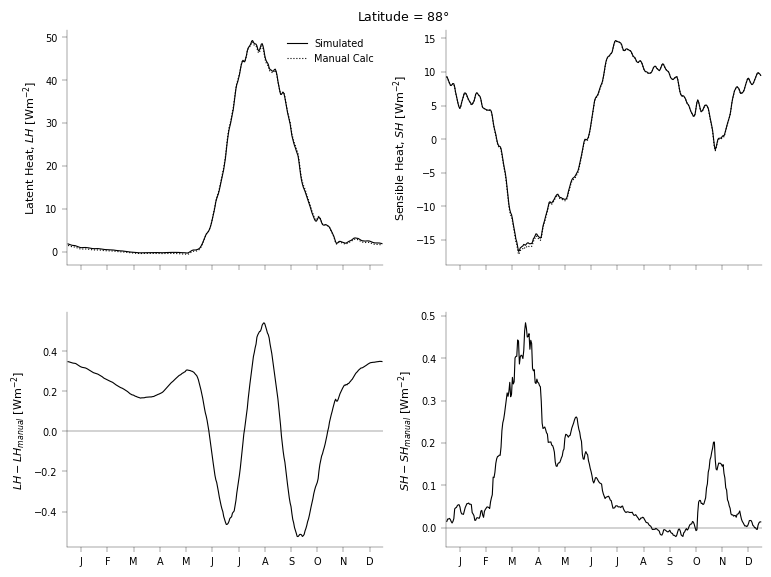

In [175]:
ind_lat_plot = -1

fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True)
ax[0, 0].plot(ds.time, smooth_func(ds.flux_lhe.isel(lat=ind_lat_plot)), color='k', label='Simulated')
ax[0, 0].plot(ds.time, smooth_func(ds.flux_lhe_manual.isel(lat=ind_lat_plot)), color='k', linestyle=':', label='Manual Calc')
ax[1, 0].plot(ds.time, (smooth_func(ds.flux_lhe.isel(lat=ind_lat_plot))-smooth_func(ds.flux_lhe_manual.isel(lat=ind_lat_plot))), color='k')
ax[1, 0].axhline(0, color='k', lw=ax_linewidth)
ax[0, 0].legend()
ax[0, 0].set_ylabel('Latent Heat, $LH$ [Wm$^{-2}$]')
ax[1, 0].set_ylabel('$LH - LH_{manual}$ [Wm$^{-2}$]')

ax[0, 1].plot(ds.time, smooth_func(ds.flux_t.isel(lat=ind_lat_plot)), color='k')
ax[0, 1].plot(ds.time, smooth_func(ds.flux_t_manual.isel(lat=ind_lat_plot)), color='k', linestyle=':')
ax[1, 1].plot(ds.time, (smooth_func(ds.flux_t.isel(lat=ind_lat_plot))-smooth_func(ds.flux_t_manual.isel(lat=ind_lat_plot))), color='k')
ax[1, 1].axhline(0, color='k', lw=ax_linewidth)
ax[0, 1].set_ylabel('Sensible Heat, $SH$ [Wm$^{-2}$]')
ax[1, 1].set_ylabel('$SH - SH_{manual}$ [Wm$^{-2}$]')

ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_xlim(-1, 360)
fig.suptitle(f'Latitude = {ds.lat[ind_lat_plot]:.2g}$\degree$', fontsize=9, y=0.91);

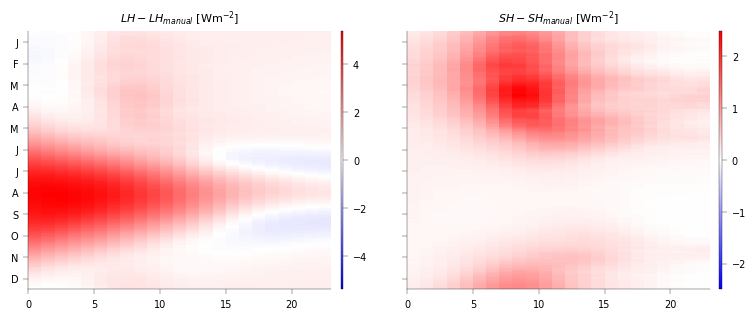

In [176]:
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
var_plot = smooth_func(ds.flux_lhe, ax=0)-smooth_func(ds.flux_lhe_manual, ax=0)
im = ax[0].pcolormesh(smooth_func(ds.flux_lhe, ax=0)-smooth_func(ds.flux_lhe_manual, ax=0), cmap='bwr', vmin=-np.abs(var_plot).max(), 
                 vmax=np.abs(var_plot).max())
fig.colorbar(im, ax=ax[0], aspect=100, pad=0.03, fraction=0.01)
var_plot = smooth_func(ds.flux_t, ax=0)-smooth_func(ds.flux_t_manual, ax=0)
im = ax[1].pcolormesh(smooth_func(ds.flux_t, ax=0)-smooth_func(ds.flux_t_manual, ax=0), cmap='bwr', 
                      vmin=-np.abs(var_plot).max(), vmax=np.abs(var_plot).max())
fig.colorbar(im, ax=ax[1], aspect=100, pad=0.03, fraction=0.01)
ax[0].set_title('$LH - LH_{manual}$ [Wm$^{-2}$]')
ax[1].set_title('$SH - SH_{manual}$ [Wm$^{-2}$]')
ax[0].set_yticks(*month_ticks)
ax[0].set_ylim(-1, 360)
ax[0].invert_yaxis()
ax[0].set_ylabel('')
ax[1].set_ylabel('');

## LH Breakdown

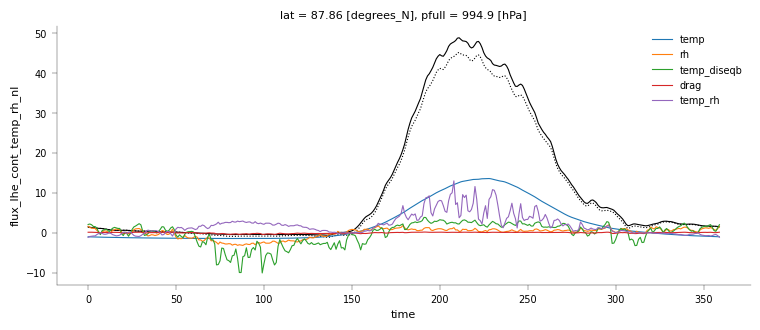

In [181]:
ind_lat_plot=-1
fig, ax = plt.subplots(1, 1, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar))
if 'flux_lhe_temp_cont' in ds:
    ax.plot(ds.time, smooth_func(ds['flux_lhe_manual'].isel(lat=ind_lat_plot)), color='k')
    ax.plot(ds.time, smooth_func(ds['flux_lhe_cont_sum'].isel(lat=ind_lat_plot)), color='k', linestyle=':')
    ds['flux_lhe_temp_cont'].isel(lat=ind_lat_plot).plot(label='temp')
    ds['flux_lhe_rh_cont'].isel(lat=ind_lat_plot).plot(label='rh')
    ds['flux_lhe_temp_diseqb_cont'].isel(lat=ind_lat_plot).plot(label='temp_diseqb')
    ds['flux_lhe_drag_cont'].isel(lat=ind_lat_plot).plot(label='drag')
    ds['flux_lhe_cont_temp_rh_nl'].isel(lat=ind_lat_plot).plot(label='temp_rh')
plt.legend()